# Galactic backtracking
The following setup shows how to use CRPropa for backtracking simulations.  
In the JF12 model the Galaxy is a sphere of 20 kpc radius.
For the magnetic field we are going to consider the regular component of the JF2012 model. The large-scale (striated) and small-scale (turbulent) random components can optionally be activated with the outcommented sections and a random seed can be set for reproducability.

In [1]:
from crpropa import *

# magnetic field setup
B = JF12Field()
#seed = 691342
#B.randomStriated(seed)
#B.randomTurbulent(seed)

# simulation setup
sim = ModuleList()
sim.add(PropagationCK(B, 1e-4, 0.1 * parsec, 100 * parsec))
obs = Observer()
obs.add(ObserverLargeSphere(Vector3d(0), 20 * kpc))
# obs.onDetection(TextOutput('galactic_backtracking.txt', Output.Event3D))
sim.add(obs)
print sim

ModuleList
  Propagation in magnetic fields using the Cash-Karp method. Target error: 0.0001, Minimum Step: 0.0001 kpc, Maximum Step: 0.1 kpc
  Observer
    ObserverLargeSphere: center = 0 0 0 Mpc, radius = 0.02 Mpc
    Flag: '' -> ''
    MakeInactive: yes




## Backtracking a single cosmic ray

Let's assume we observed a 10 EeV cosmic ray coming from the direction given by longitude and colatitude (1.95, 0.96) radian and want to investigate its direction before having traversed the Galaxy.

Backtracking corresponds to forward-tracking a particle of the opposite charge, thus we select an anti-proton, which in the HEP ID numbering scheme is denoted by a negative sign.
Assuming the cosmic ray was a proton the backtracking turns out as follows.

In [2]:
pid = - nucleusId(1,1)  # (anti-)proton
energy = 10 * EeV
position = Vector3d(-8.5, 0, 0) * kpc
lat = 0.96
lon = 1.95
direction = Vector3d()
direction.setRThetaPhi(1, lat, lon)
p = ParticleState(pid, energy, position, direction)
c = Candidate(p)

sim.run(c)
print c

d1 = c.current.getDirection()  # direction at galactic border
print 'galactic deflection %.2f radian' % direction.getAngleTo(d1)

CosmicRay at z = 0
  source:  Particle -1000010010, E = 10 EeV, x = -0.0085 0 0 Mpc, p = -0.303249 0.760996 0.57352
  current: Particle -1000010010, E = 10 EeV, x = -0.0144674 0.011531 0.00759822 Mpc, p = -0.434112 0.764527 0.476493
galactic deflection 0.16 radian


## Backtracking including uncertainties
The impact of the cosmic ray uncertainties backtracked directions can be investigated with a MC approach. In the following, the cosmic ray energy and direction are varied within the statistical uncertainties before backtracking.

In [3]:
R = Random()  # CRPropa random number generator

pid = - nucleusId(1,1)
meanEnergy = 10 * EeV
sigmaEnergy = 0.1 * meanEnergy  # 10% energy uncertainty
position = Vector3d(-8.5, 0, 0) * kpc
lat0 = 0.96
lon0 = 1.95
meanDir = Vector3d()
meanDir.setRThetaPhi(1, lat0, lon0)
sigmaDir = 0.002  # 1 degree directional uncertainty

lons, lats = [], []
for i in range(100):
    energy = R.randNorm(meanEnergy, sigmaEnergy)
    direction = R.randVectorAroundMean(meanDir, sigmaDir)

    c = Candidate(ParticleState(pid, energy, position, direction))
    sim.run(c)

    d1 = c.current.getDirection()
    lons.append(d1.getPhi())
    lats.append(d1.getTheta())


## (Optional) Plotting
Finally we are plotting a skymap of the observed direction along with the distribution of directions at the galactic border.

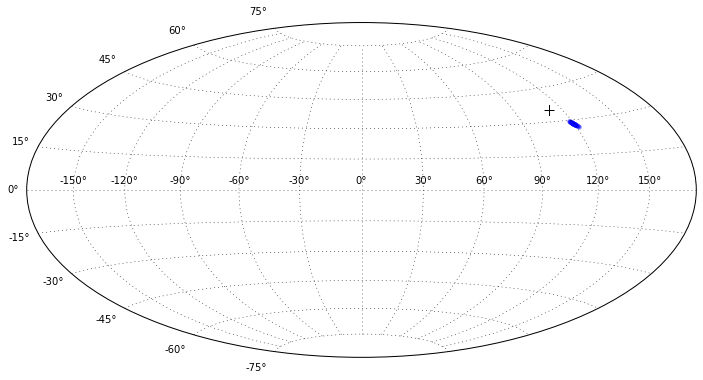

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Angle definitions:
# CRPropa uses
#   longitude (phi) [-pi, pi] with 0 pointing in x-direction
#   colatitude (theta) [0, pi] with 0 pointing in z-direction
# matplotlib expects
#   longitude [-pi, pi] with 0 = 0 degrees
#   latitude [pi/2, -pi/2] with pi/2 = 90 degrees (north)
lat0 = np.pi/2 - lat0
lats = np.pi/2 - np.array(lats)

plt.figure(figsize=(12,7))
plt.subplot(111, projection = 'hammer')
plt.scatter(lon0, lat0, marker='+', c='black', s=100)
plt.scatter(lons, lats, marker='o', c='blue', linewidths=0, alpha=0.2)
plt.grid(True)

## Backtracking to Generate a Lens

The following is an example for a backtracking simulation with a uniform isotropic coverage suitable to generate a magnetic lens. Here, anti-particle are emitted following the healpic scheme to achieve an uniform coverage of the starting direction. Please note that for production use, nside = 1024 should be used and as well a fine binning of rigidities extendig down to ~0.1 EeV is required, e.g. $10^{16.99}$ eV; $10^{17.01}$ eV; $10^{17.03}$ eV ... ;. The backtracking data can be post processed with the [create-lens.py](https://github.com/CRPropa/CRPropa3-data/blob/master/create_lens.py) program.

In [1]:
from crpropa import *
import healpy
import argparse


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('energy', type=float, help='log10(Energy / eV), i.e. 18 for 1 EeV ... ')
    parser.add_argument('--nside', type=int, help='Number of particles for sim (1024 for production)', default=16)

    args = parser.parse_args()

    # magnetic field setup
    B = JF12Field()
    seed = 1703202123
    B.randomStriated(seed)

    print('Preparing turbulent grid')
    lMin = 8 * parsec
    lMax = 272 * parsec
    turbulentGrid = Grid3f(Vector3d(0.), 256, 4 * parsec)
    crpropa.initTurbulence(turbulentGrid, 1, lMin, lMax, -11./3, seed) #Brms scales automatically
    B.setTurbulentGrid(turbulentGrid)


    # simulation setup
    sim = ModuleList()
    sim.add(PropagationCK(B, 1e-4, 0.1 * parsec, 100 * parsec))
    obs = Observer()
    obs.add(ObserverLargeSphere(Vector3d(0), 20 * kpc))

    ofname = 'galactic_backtracking_{:.2f}.h5'.format(args.energy)
    print("Writing output to {}".format(ofname))
    obs.onDetection(HDF5Output(ofname, Output.Event3D))
    sim.add(obs)

    pid = - nucleusId(1,1)  # (anti-)proton
    energy = 10**args.energy * electronvolt

    print "Running at 10**{} eV = {} EeV".format(args.energy, energy / EeV)

    position = Vector3d(-8.5, 0, 0) * kpc

    # submit a particle in every direction of a healpix map, 256 per pixel of the
    # lens
    nparts = healpy.nside2npix(args.nside)
    print('simulating {} particles'.format(nparts))
    # Use candidate vector to enable multi core processing
    cv = CandidateVector()
    print("Preparing Particles ...")
    for i in range(nparts):
        v = healpy.pix2vec(args.nside, i)
        direction = Vector3d(v[0], v[1], v[2])
        p = ParticleState(pid, energy, position, direction)
        c = crpropa.CandidateRefPtr(crpropa.Candidate(p))
        cv.push_back(c)
 
    sim.setShowProgress()
    sim.run(cv)

ImportError: No module named crpropa